# Interactive Data Maps

This notebook shows how to create maps in a notebook, *without* having to write a ton of JavaScript or Python code.  It uses [folium](https://github.com/python-visualization/folium), which leverages [Leaflet.js](http://leafletjs.com/), a popular JavaScript library to create interactive maps.  `folium` supports base maps using tilesets from [MapBox](https://www.mapbox.com/), [OpenStreetMap](http://www.openstreetmap.org/), and others, out of the box.   `folium` also makes it very easy to plot data on maps using GeoJSON and TopoJSON overlays.

## Prerequisites

You will need to install the following in order to run this notebook.

* [folium](https://github.com/python-visualization/folium), to create and render geographical maps
* [xlrd](https://pypi.python.org/pypi/xlrd), to load excel spreadsheets
* [seaborn](http://stanford.edu/~mwaskom/software/seaborn/index.html), to create nice-looking statistical plots
* [matplotlib](http://matplotlib.org/), and [pandas](http://pandas.pydata.org/) 0.15.0 or later, to enable pie plots

```
!pip install folium==0.1.3
!pip install xlrd==0.9.3
!pip install seaborn==0.5.1
!pip install matplotlib==1.4.3
!pip install pandas==0.15.2
```

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import pandas
import seaborn

## State Government Tax Collections

This notebook uses state government tax collections data from the US Census Bureau.  The [data](http://www.census.gov/govs/statetax/) are for fiscal year 2013.  The data file contains tax collections by US state governments for for a variety of tax categories, such as income, property, and sales taxes.

In [6]:
!wget -O 13staxcd.txt http://www2.census.gov/govs/statetax/13staxcd.txt

--2015-04-10 17:51:24--  http://www2.census.gov/govs/statetax/13staxcd.txt
Resolving www2.census.gov (www2.census.gov)... 23.62.6.66, 23.62.6.35, 2001:559:0:5e::1743:f66b, ...
Connecting to www2.census.gov (www2.census.gov)|23.62.6.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529 (16K) [text/plain]
Saving to: ‘13staxcd.txt’

100%[======================================>] 16,529      --.-K/s   in 0.1s    

2015-04-10 17:51:25 (127 KB/s) - ‘13staxcd.txt’ saved [16529/16529]



In [7]:
df = pandas.read_csv('13staxcd.txt', index_col='ST').dropna(axis=1)
# Because, yeah, values are in 1000s of dollars
df = df * 1000
df.head()

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
ST,,,,,,,,,,,,,,,,,,,,,
T01,322300000,99598000,762651000,1022066000,1982208000,0,0,0,360000,61052000,...,0,0,0,0,971718000,33188000,1939883000,6149000,148600000,331899000
T09,2331676000,0,6472777000,2837788000,33915885000,2416731000,3855861000,0,20785507000,5277211000,...,853570000,6629923000,26127421000,1884170000,347273000,3708389000,11122868000,1255377000,4410130000,702623000
T10,173252000,39194000,68684000,50656000,357000000,39217000,52015000,18412000,486278000,180786000,...,16027000,140068000,984423000,48228000,23159000,204049000,364795000,17690000,57290000,1802000
T11,93000,8427000,531000,36109000,0,94699000,382390000,0,165804000,0,...,9325000,0,39979000,0,0,81000,0,70259000,243000,0
T12,297958000,60236000,424369000,162962000,2242379000,211320000,242448000,87512000,657710000,329237000,...,71989000,686280000,1788471000,108872000,57517000,392397000,436118000,151136000,176710000,18419000


We need a second file that provides descriptions for the tax item codes (the TXX numbers).

In [8]:
!wget -O TaxItemCodesandDescriptions.xls http://www2.census.gov/govs/statetax/TaxItemCodesandDescriptions.xls

--2015-04-10 17:51:30--  http://www2.census.gov/govs/statetax/TaxItemCodesandDescriptions.xls
Resolving www2.census.gov (www2.census.gov)... 23.62.6.66, 23.62.6.35, 2001:559:0:5e::1743:f670, ...
Connecting to www2.census.gov (www2.census.gov)|23.62.6.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15872 (16K) [application/vnd.ms-excel]
Saving to: ‘TaxItemCodesandDescriptions.xls’

100%[======================================>] 15,872      --.-K/s   in 0s      

2015-04-10 17:51:32 (109 MB/s) - ‘TaxItemCodesandDescriptions.xls’ saved [15872/15872]



In [9]:
tax_codes_df = pandas.read_excel('TaxItemCodesandDescriptions.xls', 'Sheet1', index_col='Item Code')
tax_codes_df.head()

,Description
Item Code,
T01,Property Taxes
T09,General Sales and Gross Receipts Taxes
T10,Alcoholic Beverages Sales Tax
T11,Amusements Sales Tax
T12,Insurance Premiums Sales Tax


## Total taxes collected

The sum of taxes collected over by state and local governments for all categories in fiscal year 2013 is over **$846 billion**, with a 'b'.

In [10]:
print '${:,}'.format(df.sum().sum())

$846,214,995,000


## Taxes by category

According to the data [source](http://www.census.gov/govs/statetax/):

>The Annual Survey of State Government Tax Collections (STC) provides a summary of taxes collected by state for 5 broad tax categories and up to 25 tax subcategories. These tables and data files present the details on tax collections by type of tax imposed and collected by state governments.

The only thing missing from the data thus far are the "5 broad tax categories", and which of the 25 subcategories make up each one.   We had to [look this up](http://www.census.gov/govs/classification/), and download another [Excel file](http://www2.census.gov/govs/estimate/methodology_for_summary_tabulations.xls).  There's also this [report](http://www2.census.gov/govs/statetax/2013stcreport.pdf), which provides some details about tax categorization, but also seems to contradict the Excel spreadsheet. Oh, the humanity.

In [11]:
!wget -O agg_tax_categories.xls http://www2.census.gov/govs/estimate/methodology_for_summary_tabulations.xls

--2015-04-10 17:51:37--  http://www2.census.gov/govs/estimate/methodology_for_summary_tabulations.xls
Resolving www2.census.gov (www2.census.gov)... 23.62.6.66, 23.62.6.35, 2001:559:0:5e::1743:f66b, ...
Connecting to www2.census.gov (www2.census.gov)|23.62.6.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65024 (64K) [application/vnd.ms-excel]
Saving to: ‘agg_tax_categories.xls’

100%[======================================>] 65,024      --.-K/s   in 0.004s  

2015-04-10 17:51:44 (17.7 MB/s) - ‘agg_tax_categories.xls’ saved [65024/65024]



In [12]:
tmp = pandas.read_excel('agg_tax_categories.xls')
tmp[8:21].dropna(how='all').dropna(how='all', axis=1).head()

,2010 Publication Aggregates -- State & Local Government Finance,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 11
8,8,Total Taxes,NaN,NaN,NaN,"T01, T09, T10, T11, T12, T13, T14, T15, T16, T..."
9,9,NaN,Property Tax,NaN,NaN,T01
10,10,NaN,Sales and Gross Receipts,NaN,NaN,"T09, T10, T11, T12, T13, T14, T15, T16, T19"
11,11,NaN,NaN,General Sales,NaN,T09
12,12,NaN,NaN,Selective Sales Tax,NaN,"T10, T11, T12, T13, T14, T15, T16, T19"


After some investigation, we can write a short function to retrieve the major tax category by tax item code.

In [13]:
def category(tax_item):
    '''Return tax category for the tax item code.'''
    if tax_item == 'T01':
        return 'Property Taxes'
    elif tax_item in ['T40', 'T41']:
        return 'Income Taxes'
    elif tax_item in ['T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T19']:
        return 'Sales and Gross Receipts Taxes'
    elif tax_item in ['T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29']:
        return 'License Taxes'
    return 'Other Taxes'

Sum all taxes collected by broad category.

In [14]:
# assign broad category to each tax item code
tmp = df.copy()
tmp['Category'] = tmp.index.map(category)

# aggregate taxes collected by each state by broad category
by_category = tmp.groupby('Category').sum()

# sum across all states
totals_by_category = by_category.sum(axis=1)
print totals_by_category.map('${:,}'.format)

Category
Income Taxes                      $354,658,475,000
License Taxes                      $55,485,079,000
Other Taxes                        $30,226,907,000
Property Taxes                     $13,129,395,000
Sales and Gross Receipts Taxes    $392,715,139,000
dtype: object


Plot the total taxes collected for by broad category.

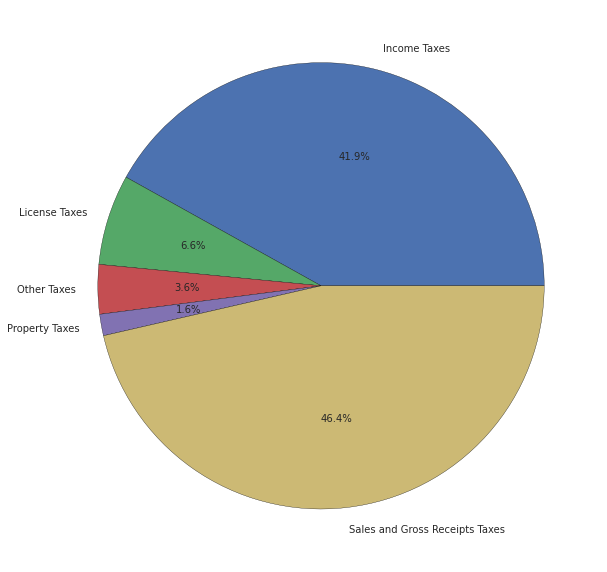

In [15]:
totals_by_category.plot(kind='pie', labels=totals_by_category.index, 
                        figsize=(10,10), autopct='%.1f%%')

Here is a [violin plot](http://stanford.edu/~mwaskom/software/seaborn/examples/elaborate_violinplot.html) (a combination of boxplot and kernel density plot) that shows the distribution of taxes collected for each category.  

* The median sales and income taxes collected is below \$5 billion (each).
* The majority of states collect less than \$10 billion each in sales and income taxes.
* Some states collect as much as \$75 billion in income tax, and as much as \$48 billion in sales tax.  Ouch.

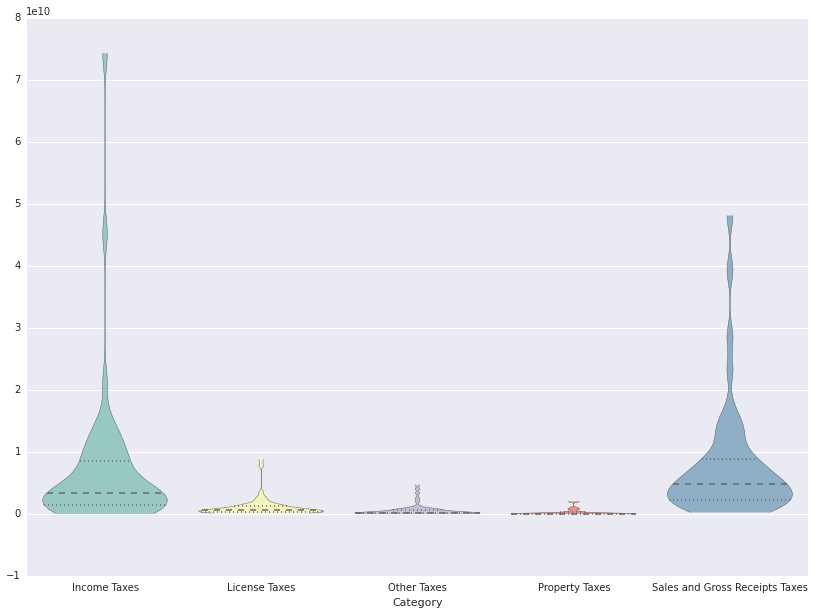

In [16]:
data = by_category.T
fig, ax = plt.subplots(figsize=(14,10))
seaborn.violinplot(data, color="Set3", bw=.2, cut=.6,
                   lw=.5, inner="box", inner_kws={"ms": 6}, ax=ax)

In [17]:
print data[['Income Taxes', 'Sales and Gross Receipts Taxes']].describe()

       Income Taxes  Sales and Gross Receipts Taxes
count  5.000000e+01                    5.000000e+01
mean   7.093170e+09                    7.854303e+09
std    1.218651e+10                    9.424387e+09
min    0.000000e+00                    2.495860e+08
25%    1.496777e+09                    2.293244e+09
50%    3.421451e+09                    4.749209e+09
75%    8.580206e+09                    8.918576e+09
max    7.427100e+10                    4.807458e+10


## Taxes by state

Sum the taxes across all categories and view the states that collect the most taxes.

In [18]:
taxes_by_state = df.sum().sort(inplace=False, ascending=False)
taxes_by_state[:10].map('${:,}'.format)

CA    $133,184,246,000
NY     $73,667,171,000
TX     $51,714,295,000
IL     $38,715,320,000
FL     $34,588,478,000
PA     $33,965,626,000
NJ     $29,076,881,000
OH     $27,330,948,000
MI     $25,082,654,000
MA     $23,901,047,000
dtype: object

It may not surprise anyone that California and New York top the list; however, it may surprise some that California collected almost twice as much tax revenue as New York.  Here is a bar chart to help visualize the magnitude of taxes collected by state.

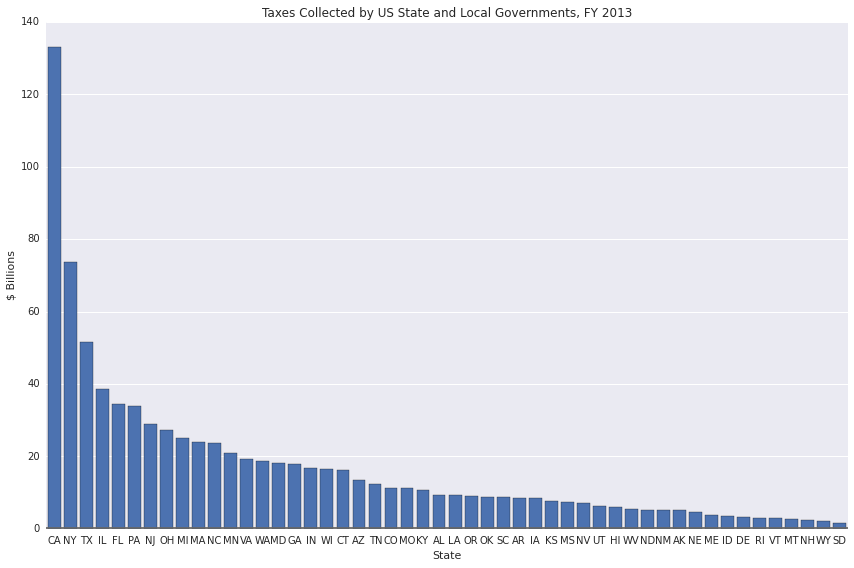

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
data = taxes_by_state.reset_index()
data.columns = ['State', 'Taxes']
# plot values in $ billions
seaborn.barplot(data.index, data.Taxes / 1000000000,
                ci=None, hline=.1, ax=ax)
ax.set_xticklabels(data.State)
ax.set_ylabel('$ Billions')
ax.set_xlabel('State')
ax.set_title('Taxes Collected by US State and Local Governments, FY 2013')
plt.tight_layout()

## Let's map our data
We want to overlay our tax data over a map of the United States.  To do this, we'll use the following:

1. A [TopoJSON](https://github.com/mbostock/topojson/wiki) file that contains geographic borders of US states (and counties).
2. [US FIPS codes](http://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) from the US Census bureau ([data file](http://www2.census.gov/geo/docs/reference/state.txt)).  We'll use these to bind our data set to the state geometries in our TopoJSON file.
3. The [folium](https://github.com/python-visualization/folium) Python library to do the heavy lifting of rendering our map.

### Tax Data

Combine the data for the 25 tax subcategories with the cumulative amounts for the 5 broad categories.  This will allow us to map both sets.

In [20]:
# the aggregate data by broad category
tmp = by_category.T

# make up our own tax item codes for broad categories
codes = ['I','L','O','P','S']

# create complete list of category names
category_names = tax_codes_df.Description.append(
    pandas.Series(tmp.columns, index=codes)
)

# merge broad category data with data for 25 subcategories
tmp.columns = codes
data = df.T.merge(tmp, left_index=True, right_index=True)
data.head()

,T01,T09,T10,T11,T12,T13,T14,T15,T16,T19,...,T41,T50,T51,T53,T99,I,L,O,P,S
AL,322300000,2331676000,173252000,93000,297958000,530244000,1557000,737619000,120110000,514866000,...,382202000,18000,42155000,119424000,0,3584722000,490475000,161597000,322300000,4707375000
AK,99598000,0,39194000,8427000,60236000,41608000,0,4295000,69175000,26651000,...,630941000,0,0,4016966000,0,630941000,135720000,4016966000,99598000,249586000
AZ,762651000,6472777000,68684000,531000,424369000,781426000,234000,21013000,315428000,122246000,...,662026000,0,0,29829000,0,4059733000,412769000,29829000,762651000,8206708000
AR,1022066000,2837788000,50656000,36109000,162962000,455914000,3113000,0,237328000,235333000,...,402874000,92000,30190000,80862000,24623000,3052451000,356920000,135767000,1022066000,4019203000
CA,1982208000,33915885000,357000000,0,2242379000,5492850000,14088000,676997000,868703000,4506678000,...,7462000000,0,0,37732000,74978000,74271000000,8743748000,112710000,1982208000,48074580000


### TopoJSON File

We created a TopoJSON file of US borders using [us-atlas](https://github.com/mbostock/us-atlas).  Creation of this file is beyond our scope here, but you can download it from our GitHub repository.

In [21]:
!wget -O us-states-10m.json https://raw.githubusercontent.com/knowledgeanyhow/notebooks/master/tax-maps/data/us-states-10m.json

--2015-04-10 17:52:17--  https://raw.githubusercontent.com/knowledgeanyhow/notebooks/master/tax-maps/data/us-states-10m.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.27.75.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.27.75.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651048 (636K) [text/plain]
Saving to: ‘us-states-10m.json’

100%[======================================>] 651,048     1.77MB/s   in 0.4s   

2015-04-10 17:52:22 (1.77 MB/s) - ‘us-states-10m.json’ saved [651048/651048]



In [22]:
us_topo_map = 'us-states-10m.json'

import os
assert os.path.isfile(us_topo_map)
statinfo = os.stat(us_topo_map)
assert statinfo.st_size > 0

### U.S. FIPS Codes

Our tax data is indexed by state.  We need a way to bind our data to the state geometries in our map.  The geometries in our TopoJSON file are keyed by FIPS codes (Federal Information Processing Standard).  So we need to obtain the FIPS codes for US states (from the US Census Bureau), and add them to our data.

In [23]:
!wget -O us_state_FIPS.txt http://www2.census.gov/geo/docs/reference/state.txt

--2015-04-10 17:52:26--  http://www2.census.gov/geo/docs/reference/state.txt
Resolving www2.census.gov (www2.census.gov)... 23.62.6.66, 23.62.6.35, 2001:559:0:5e::1743:f66b, ...
Connecting to www2.census.gov (www2.census.gov)|23.62.6.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485 (1.5K) [text/plain]
Saving to: ‘us_state_FIPS.txt’

100%[======================================>] 1,485       --.-K/s   in 0s      

2015-04-10 17:52:27 (7.11 MB/s) - ‘us_state_FIPS.txt’ saved [1485/1485]



In [24]:
fips = pandas.read_csv('us_state_FIPS.txt', delimiter='|', index_col='STUSAB')
fips.head()

,STATE,STATE_NAME,STATENS
STUSAB,,,
AL,1,Alabama,1779775
AK,2,Alaska,1785533
AZ,4,Arizona,1779777
AR,5,Arkansas,68085
CA,6,California,1779778


Add FIPS column to our data.

In [25]:
data['FIPS'] = data.index.map(lambda x: fips.loc[x]['STATE'])
data['FIPS'].head()

AL    1
AK    2
AZ    4
AR    5
CA    6
Name: FIPS, dtype: int64

### Folium

Folium utilizes IPython's rich display to render maps as HTML.  Here are two functions that use different mechanisms to render a map in a notebook.  Either will work in modern browsers.

<div class="alert alert-block alert-warning" style="margin-top: 20px">As of this writing, folium==0.1.3 has a <a href="https://github.com/python-visualization/folium/issues/83">defect</a> that prevents some browsers from rendering maps within a notebook if the notebook server is running over https.  The issue is caused by folium hardcoding http as the protocol to external CSS and JavaScript dependencies.  If your browser prevents loading mixed content, the map may fail to display.  Chrome users can opt for more lax security using <a href="https://support.google.com/chrome/answer/1342714?hl=en">this workaround</a>. 
</div>

<div class="alert alert-block alert-info" style="margin-top: 20px">The maps below may not render in <a href="http://nbviewer.ipython.org/">nbviewer</a> because they embed JavaScript.
</div>

In [26]:
import folium
from IPython.display import HTML

def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

Now we create a function that accepts a tax code, creates a basemap of the United States, and adds a TopoJSON overlay with the appropriate state tax data bound to it.

In [27]:
def create_tax_map(tax_code, path='tax_map.html'):
    '''
    Create a base map with tax data bound to a GeoJSON overlay.
    '''
    # lookup tax category name
    tax_name = category_names.loc[tax_code] + ' ($ Millions)'
    
    # lookup tax data
    d = data[['FIPS',tax_code]].copy()
    d[tax_code] = d[tax_code] / 1000000L

    # compute a color scale based on data values
    max = d[tax_code].max()
    color_scale = [max*q for q in [0, 0.1, 0.25, 0.5, 0.75, 0.95]]
    
    # create base map
    map = folium.Map(location=[40, -99], zoom_start=4, width=800)
    
    # add TopoJSON overlay and bind data
    map.geo_json(geo_path=us_topo_map, data_out='tax_map.json', 
                 data=d, columns=d.columns,
                 key_on='feature.id',
                 threshold_scale=color_scale,
                 fill_color='PuBuGn', line_opacity=0.3,
                 legend_name=tax_name,
                 topojson='objects.states')
    map.create_map(path=path)
    return map

inline_map(create_tax_map('T40'))

### Add a widget

Use a widget to choose the tax category and render the map interactively.

In [28]:
from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact

tax_categories = category_names.to_dict()
tax_categories = dict(zip(tax_categories.values(), tax_categories.keys()))
dropdown = widgets.Dropdown(options=tax_categories, value='T40', description='Tax:')

def show_map(tax_code):
    display(inline_map(create_tax_map(tax_code)))

widgets.interact(show_map, tax_code=dropdown)

<function __main__.show_map>

<div class="alert" style="border: 1px solid #aaa; background: radial-gradient(ellipse at center, #ffffff 50%, #eee 100%);">
<div class="row">
    <div class="col-sm-1"><img src="https://knowledgeanyhow.org/static/images/favicon_32x32.png" style="margin-top: -6px"/></div>
    <div class="col-sm-11">This notebook was created using <a href="https://knowledgeanyhow.org">IBM Knowledge Anyhow Workbench</a>.  To learn more, visit us at <a href="https://knowledgeanyhow.org">https://knowledgeanyhow.org</a>.</div>
    </div>
</div>